## Development of SVR Model

This notebook reproduces Fig. S7

Authors: Johannes Betz and Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [5]:
import numpy as np
import pandas as pd
import glob 
import difflib
import time
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from sklearn import svm 
from sklearn.inspection import permutation_importance
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, gaussian_kde
from scipy.stats import binned_statistic, binned_statistic_2d
from joblib import dump, load
# function to calculate standard error of the mean
se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'

In [6]:
# load IDRome database
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)

# load randomly drawn indices for 20%, 30%, and 60% of dataset
inds10 = np.load('svr_model/inds10.npy') # hold-out test set
inds30 = np.load('svr_model/inds30.npy') 
inds60 = np.load('svr_model/inds60.npy')

# input features
features = ['scd','shd','kappa','fcr','mean_lambda']
feature_dict = {'scd':'SCD','shd':'SHD',
                'mean_lambda':r'$\langle \lambda \rangle$',
                'fcr':'FCR','kappa':'$\kappa$'}

#### Grid search of hyperparameters

In [7]:
#eps_range = np.concatenate((np.arange(0,0.0012,0.0002),np.arange(0.002,0.012,0.002),np.arange(0.02,0.12,0.02)))
eps_range = np.array([0.005,0.01,0.02])
#c_range = np.arange(60,100,1)
c_range = np.array([68,78,88])

#write pearson correlations to array
pearsons = np.zeros((len(eps_range),len(c_range)))
for eps_i,eps in enumerate(eps_range):
    for c_i,c in enumerate(c_range):
        X = np.array(df_idrome[features])[inds30]
        y = np.array(df_idrome['nu'])[inds30]

        model = svm.SVR(epsilon=eps,C=c)
        model.fit(X,y)

        X_test = np.array(df_idrome[features])[inds60]
        y_pred = model.predict(X_test)

        y_sim = np.array(df_idrome['nu'])[inds60]
        
        pearson_corr = pearsonr(y_pred,y_sim)
        pearsons[eps_i][c_i] = pearson_corr[0]
        
eps_i_max, c_i_max = np.where(pearsons==pearsons.max())
opt_eps = eps_range[eps_i_max]
opt_c = c_range[c_i_max]

print('Optimal Hyperparameters')
print('epsilon =',opt_eps,', C =',opt_c)

Optimal Hyperparameters
epsilon = [0.01] , C = [78]


#### Train SVR model

In [8]:
X = np.array(df_idrome[features])[inds30]
y = np.array(df_idrome['nu'])[inds30]
model = svm.SVR(epsilon=opt_eps,C=opt_c,verbose=True)
model.fit(X,y)

[LibSVM]..................................................................................................................
*............................................................................................................................................................................................................................................
*.................................*............
*
optimization finished, #iter = 394252
obj = -3873.871541, rho = -0.442972
nSV = 4782, nBSV = 4542


SVR(C=array([78]), epsilon=array([0.01]), verbose=True)

#### Export model using joblib

In [ ]:
dump(model, 'svr_model/svr_model.joblib') 

#### Load model using joblib

In [9]:
model = load('svr_model/svr_model.joblib') 

#### Calculate $\nu_{\text{SVR}}$ for all sequences

In [ ]:
for seq_name in df_idrome.index:
    df_idrome.loc[seq_name,'nu_svr'] = model.predict(df_idrome.loc[seq_name,features].values.reshape(1, -1))
df_idrome.nu_svr = df_idrome.nu_svr.apply(lambda x: round(x,3))
df_idrome.to_csv('IDRome_DB.csv')

#### Scaling exponents in validation set

In [11]:
features_60 = df_idrome[features].iloc[inds60].values
nu_60 = df_idrome.iloc[inds60].nu.values

####  Permutation feature importance testing

In [12]:
per_imp = permutation_importance(model,features_60,nu_60)

#### Fig. S7

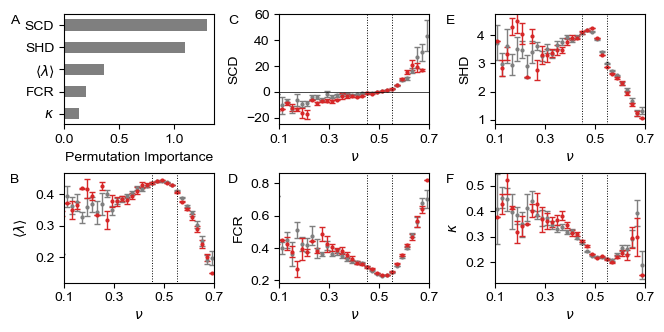

In [13]:
f, axes = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(6.6,3.3))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

features = np.array(features)
sorted_idx = per_imp.importances_mean.argsort()
axes[0,0].barh(features[sorted_idx],per_imp.importances_mean[sorted_idx],color='tab:gray',height=.5)
feature_labels = [feature_dict[f] for f in features[sorted_idx]]
axes[0,0].set_yticks(range(5))
axes[0,0].set_yticklabels(feature_labels)
axes[0,0].set_xlabel('Permutation Importance')

features = ['scd','shd','mean_lambda','fcr','kappa']
labels = ['SCD','SHD',r'$\langle \lambda \rangle$','FCR',r'$\kappa$']

bins = np.arange(0, .701, .02)
x = bins[:-1]+.01

for ax,feature,label in zip(axes.flatten()[1:],features,labels):

    average = binned_statistic(df_idrome.nu,df_idrome[feature],bins=bins)[0]
    standard_error = binned_statistic(df_idrome.nu,df_idrome[feature],statistic=se,
                                     bins=bins)[0]

    ax.errorbar(x,average,yerr=standard_error,ms=2,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,label=label,color='tab:gray')
    
    average = binned_statistic(df_idrome.nu_svr,df_idrome[feature],bins=bins)[0]
    standard_error = binned_statistic(df_idrome.nu_svr,df_idrome[feature],statistic=se,
                                     bins=bins)[0]

    ax.errorbar(x,average,yerr=standard_error,ms=2,marker='o',lw=0,zorder=0,
             elinewidth=1,capsize=2,capthick=1,label=label,color='tab:red')

    ax.set_ylabel(label)
    ymin = np.nanmin(average)
    ymin = ymin*1.3 if ymin <0 else ymin*.8
    ymax = np.nanmax(average)*1.05
    ax.vlines([.45,.55],ymin=-40,ymax=80,color='k',ls=':',lw=.7)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(.1,.7)
    ax.set_xticks(np.arange(.1,.71,.2))
    ax.set_xlabel('$\\nu$')
    
axes[0,1].hlines(0,0,1,lw=.5,color='k')
axes[0,1].set_ylim(-25,60)
    
f.text(0.01, .93, 'A', fontsize=10)
f.text(0.34, .93, 'C', fontsize=10)
f.text(0.67, .93, 'E', fontsize=10)

f.text(0.01, .45, 'B', fontsize=10)
f.text(0.34, .45, 'D', fontsize=10)
f.text(0.67, .45, 'F', fontsize=10)
    
plt.tight_layout()
plt.savefig('figs/figS7.pdf',dpi=300)
plt.show()